In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# If you use something from this notebook please vote up!!

In [2]:
train_set = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
X = train_set.drop(['SalePrice'], axis = 1)#
y = train_set['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=0)

In [5]:
y_train.describe()

count      1168.000000
mean     180808.898973
std       78499.911304
min       34900.000000
25%      130000.000000
50%      163000.000000
75%      215000.000000
max      755000.000000
Name: SalePrice, dtype: float64

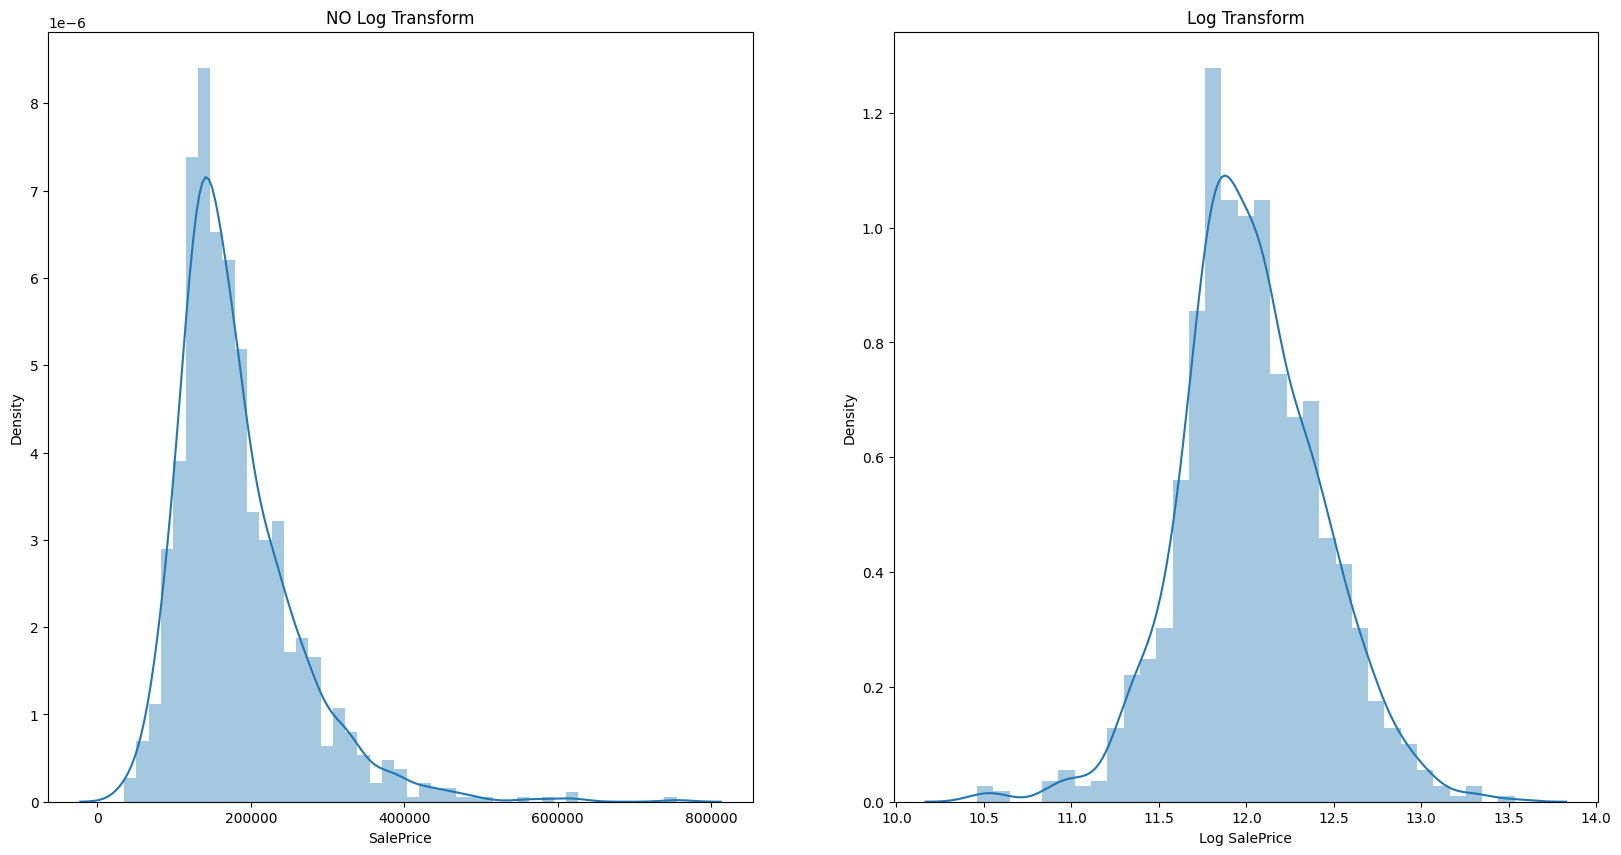

In [6]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(y_train, kde=True)
plt.title("NO Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(y_train), kde=True)
plt.xlabel("Log SalePrice")
plt.title("Log Transform")

plt.show()

In [7]:
print(X_train.shape, '\n')
X_train.info()

(1168, 80) 

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 618 to 684
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    956 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          71 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18 

In [8]:
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

X = train_set.drop(['SalePrice'], axis = 1)#
y = train_set['SalePrice']

X.loc[:, 'TotalArea']= X.loc[:, 'LotFrontage'] + X.loc[:, 'LotArea']
X.loc[:, "totalFlrSF"] = X.loc[:, "1stFlrSF"] + X.loc[:, "2ndFlrSF"]
X.loc[:, 'HasPool'] = [1 if pool > 0 else 0 for pool in X.loc[:, "PoolArea"]]
X.loc[:, 'HasGarage'] = [1 if gar > 0 else 0 for gar in X.loc[:, "GarageYrBlt"]]

X_train, X_val, y_train, y_val = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=0)

# categorial columns: dtype == object or number of unique values < 10
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# numerical columns: dtype == int64 or float64 (although we saw in the X_train.info() there were only int64 in the dataset)
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

numerical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('scaling', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist'))
])

preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)])

X_train[categorical_cols] = X_train[categorical_cols].fillna("None")

models = {
    'SVR':SVR(),
    'XGBRegressor':XGBRegressor(),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    'SGDRegressor':SGDRegressor(),
    'LinearRegression':LinearRegression(),
    'LGBMRegressor':LGBMRegressor(),
    'CatBoostRegressor': CatBoostRegressor(verbose = False),
    'RandomForestRegressor':RandomForestRegressor()
}

list_modelName=[]
list_predict=[]
for model_name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), 
                           ("regressor", model)])
    pred=pipe.fit(X_train, np.log(y_train)).predict(X_val) #predict
    
    score=np.sqrt(mean_squared_error(np.log(y_val), pred))
    
    list_modelName.append(model_name) #model name
    list_predict.append(score) #model score

models_scores=pd.DataFrame([list_modelName, list_predict]).T.rename(columns=({0:'Model', 1:'Score'})).sort_values('Score')
models_scores

,Model,Score
7,CatBoostRegressor,0.122632
6,LGBMRegressor,0.132943
8,RandomForestRegressor,0.138963
1,XGBRegressor,0.147207
0,SVR,0.155172
2,Ridge,0.196545
5,LinearRegression,0.238359
3,ElasticNet,0.389117
4,SGDRegressor,1.995291


In [9]:
X = train_set.drop(['SalePrice'], axis = 1)#
y = train_set['SalePrice']

X.loc[:, 'TotalArea']= X.loc[:, 'LotFrontage'] + X.loc[:, 'LotArea']
X.loc[:, "totalFlrSF"] = X.loc[:, "1stFlrSF"] + X.loc[:, "2ndFlrSF"]
X.loc[:, 'HasPool'] = [1 if pool > 0 else 0 for pool in X.loc[:, "PoolArea"]]
X.loc[:, 'HasGarage'] = [1 if gar > 0 else 0 for gar in X.loc[:, "GarageYrBlt"]]

X_train, X_val, y_train, y_val = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=0)

categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

numerical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('scaling', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist'))
])

preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)])

X_train[categorical_cols] = X_train[categorical_cols].fillna("None")

cat_reg = CatBoostRegressor(verbose = False,
                           learning_rate = 0.1,
                           iterations = 1500,
                           objective = 'RMSE')

pipe = Pipeline(steps=[("preprocessor", preprocessor), 
                       ("regressor", cat_reg)])
pipe.fit(X_train, np.log(y_train))

y_pred = pipe.predict(X_val)
score = np.sqrt(mean_squared_error(np.log(y_val), y_pred))
print(f'RMSE Score on Test set: {score}')

RMSE Score on Test set: 0.12102102286126419


In [10]:
teste = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

teste[categorical_cols] = teste[categorical_cols].fillna("None")

teste.loc[:, 'TotalArea']= teste.loc[:, 'LotFrontage'] + teste.loc[:, 'LotArea']
teste.loc[:, "totalFlrSF"] = teste.loc[:, "1stFlrSF"] + teste.loc[:, "2ndFlrSF"]
teste.loc[:, 'HasPool'] = [1 if pool > 0 else 0 for pool in teste.loc[:, "PoolArea"]]
teste.loc[:, 'HasGarage'] = [1 if gar > 0 else 0 for gar in teste.loc[:, "GarageYrBlt"]]

teste[categorical_cols] = teste[categorical_cols].fillna("None")

pipe.fit(X, np.log(y))
p = pipe.predict(teste)

d = {'id': teste['Id'], 'SalePrice': np.exp(p)} 

predictions = pd.DataFrame(d)
predictions.to_csv("/kaggle/working/submission.csv", index=False) # Score: 0.13178 in the leaderboard 